### IMPORTING LIBRARIES

In [409]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk import word_tokenize
import re
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.stem.porter import PorterStemmer

import matplotlib.pyplot as plt
%matplotlib inline

In [410]:
train = pd.read_csv('assignment_data_train.csv') #loading the train dataset 

In [411]:
test = pd.read_csv('assignment_data_test.csv')   #loading the test dataset

In [412]:
#inspecting the shape(rows and columns)
print(train.shape) 
print(test.shape)

(14037, 3)
(4680, 2)


In [413]:
#inspecting the column names 
print(train.columns)
print(test.columns)

Index(['EVENT_TYPE', 'comment', 'EVENT_ID'], dtype='object')
Index(['comment', 'EVENT_ID'], dtype='object')


In [414]:
#displaying the first 5 rows
train.head()

,EVENT_TYPE,comment,EVENT_ID
0,PROMISE_TO_PAY,PROMISE TO PAY BY CASH ON 21 NOV 2018,9346
1,RINGING,RNG.,10430
2,NOT_CONTACTABLE,ASSIGNED TO AGENCY AG ENTERPRISES,21762
3,PAID,PAID,19014
4,PROMISE_TO_PAY,PTP GIVEN BY CUSTOMER TO AGENCY,10400


In [415]:
#displaying the first 5 rows
test.head()

,comment,EVENT_ID
0,CM HAS MADE THE PYMT OF RS 4636 THROUGH AGENCY...,24619
1,VISITED AT CM'S RESIDENCY ADDRESS BUT CM IS NO...,28548
2,OUT OF SERVICE.,4351
3,XXX-XXX-XXXX RNG,25826
4,CM SAID HE MAKE THE PAYMENT ON 1 FEB,27187


In [416]:
#Number of each Event Type present
train['EVENT_TYPE'].value_counts()

RINGING               3752
PAID                  3370
PROMISE_TO_PAY        2791
NOT_CONTACTABLE       1813
CASH_PICK_UP          1390
FOLLOW_UP              782
NOT_WILLING_TO_PAY     139
Name: EVENT_TYPE, dtype: int64

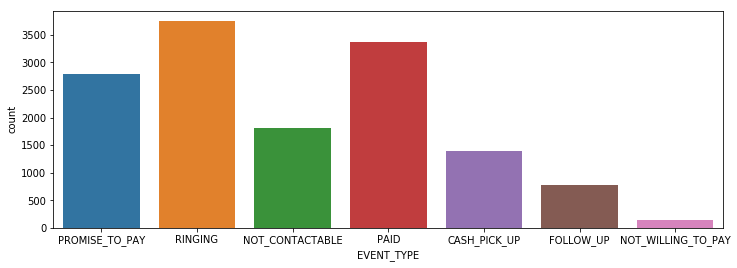

In [417]:
#Displaying the count 
plt.figure(figsize=(12,4)) 
sns.countplot(x='EVENT_TYPE', data=train)

In [418]:
#Finding out the most comman words and plotting them
nltk.download('stopwords')


def freq_words(x, terms=30):
    all_words= ''.join([text for text in x])
    all_words=all_words.split()
    
    fdist= FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
    
    
    d = words_df.nlargest(columns="count", n=terms)
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d , x="word", y="count")
    ax.set_label(s="Count")
    plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nyalazone-13/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


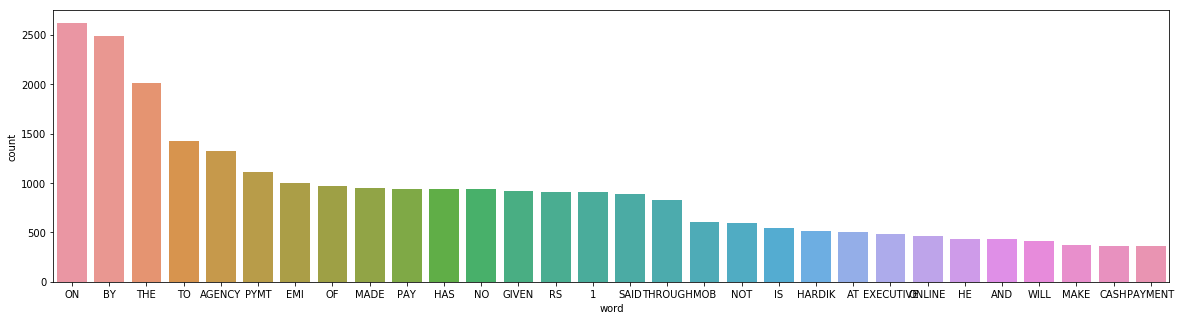

In [419]:
freq_words(train['comment'])

In [420]:
train['comment'] = train['comment'].str.replace("[^a-zA-Z#]", " ")

In [421]:
#removing stop words
stop_words = stopwords.words('english')

In [422]:
#function for removing stop words
def remove_stopwords(com):
    comm_new = " ".join([i for i in com if i not in stop_words])
    return comm_new

train['comment'] = train['comment'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

comments = [remove_stopwords(r.split()) for r in train['comment']]

comments = [r.lower() for r in comments]

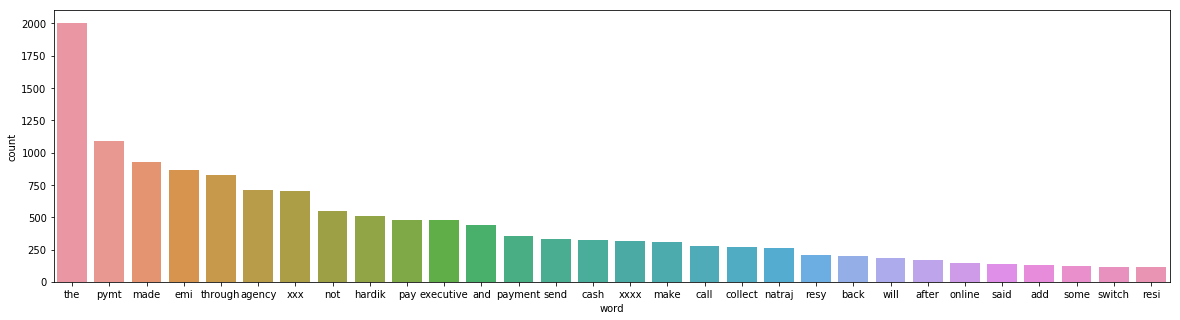

In [423]:
freq_words(comments, 30)

In [424]:
#cleaned train dataset
train.head()

,EVENT_TYPE,comment,EVENT_ID
0,PROMISE_TO_PAY,PROMISE PAY CASH NOV,9346
1,RINGING,RNG,10430
2,NOT_CONTACTABLE,ASSIGNED AGENCY ENTERPRISES,21762
3,PAID,PAID,19014
4,PROMISE_TO_PAY,PTP GIVEN CUSTOMER AGENCY,10400


### CHECKING NULL VALUES IF ANY

In [425]:
train['EVENT_TYPE'].isnull().sum()

0

In [426]:
train['comment'].isnull().sum()

0

In [427]:
train['EVENT_ID'].isnull().sum()

0

### FURTHER CLEANING THE TEXT

In [428]:

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    line = re.sub("(^|\W)\d+($|\W)", " ", text)
    text = text.strip(' ')
    return text

In [429]:
train['comment'] = train['comment'].map(lambda com : clean_text(com))
train['comment'][0:5]

0           promise pay cash nov
1                            rng
2    assigned agency enterprises
3                           paid
4      ptp given customer agency
Name: comment, dtype: object

### BUILDING THE MODEL

In [430]:
# Specifying the traget variable and the feature which will be trained
train_data = train.comment
test_data = test.comment
target = train.EVENT_TYPE

In [431]:
train['EVENT_TYPE'].unique() #Checking unique values 

array(['PROMISE_TO_PAY', 'RINGING', 'NOT_CONTACTABLE', 'PAID',
       'CASH_PICK_UP', 'FOLLOW_UP', 'NOT_WILLING_TO_PAY'], dtype=object)

In [432]:
#Using Model Logistic Regression
#Defined a Pipleline for the same 
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(train_data, target)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip...penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))])

In [433]:
#predictions (in an array)
y_pred

array(['PAID', 'RINGING', 'NOT_CONTACTABLE', ..., 'NOT_CONTACTABLE',
       'PROMISE_TO_PAY', 'PROMISE_TO_PAY'], dtype=object)

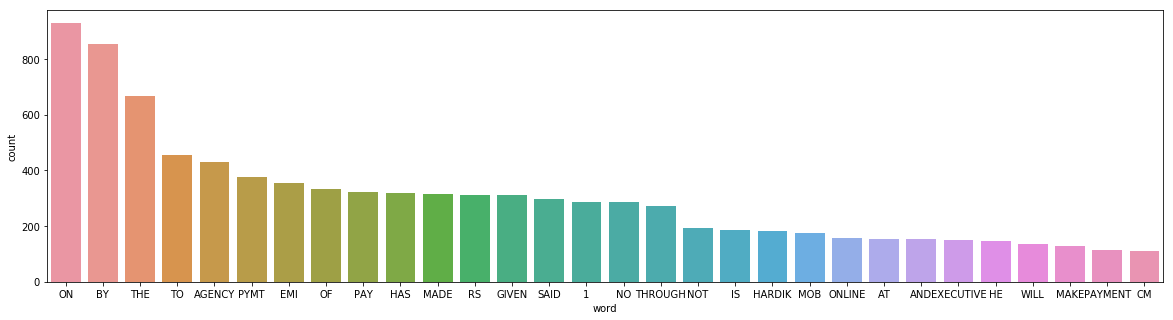

In [434]:
#preprocessing test data
freq_words(test['comment'])

In [435]:
test['comment'] = test['comment'].str.replace("[^a-zA-Z#]", " ")

In [436]:
def remove_stopwords(com):
    comm_new = " ".join([i for i in com if i not in stop_words])
    return comm_new

test['comment'] = test['comment'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

comments = [remove_stopwords(r.split()) for r in test['comment']]

comments = [r.lower() for r in comments]

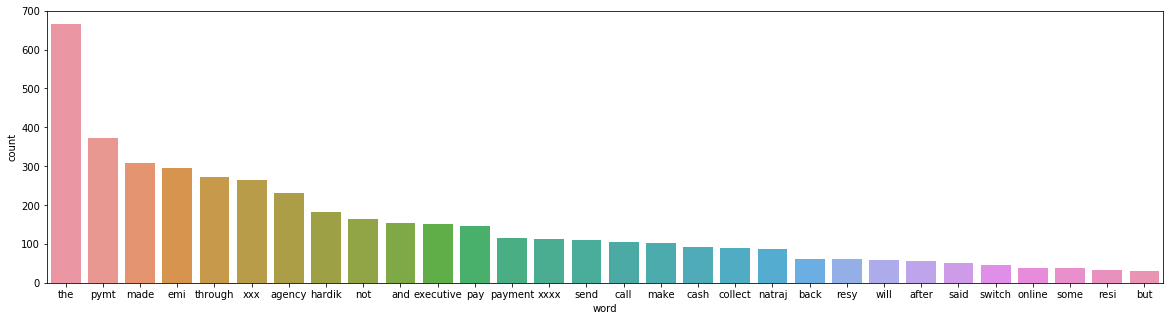

In [437]:
freq_words(comments, 30)

In [438]:
test.head()

,comment,EVENT_ID
0,HAS MADE THE PYMT THROUGH AGENCY,24619
1,VISITED RESIDENCY ADDRESS BUT NOT AVAILABLE LE...,28548
2,OUT SERVICE,4351
3,XXX XXX XXXX RNG,25826
4,SAID MAKE THE PAYMENT FEB,27187


In [439]:
test['comment'] = test['comment'].map(lambda com : clean_text(com))

test['comment'][0:5]

0                     has made the pymt through agency
1    visited residency address but not available le...
2                                          out service
3                                     xxx xxx xxxx rng
4                            said make the payment feb
Name: comment, dtype: object

In [440]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    line = re.sub("(^|\W)\d+($|\W)", " ", text)
    line = re.sub("[^a-zA-Z]", " ", text)
    text = text.strip(' ')
    return text

In [441]:
test['comment'] = test['comment'].map(lambda com : clean_text(com))

test['comment'][0:5]

0                     has made the pymt through agency
1    visited residency address but not available le...
2                                          out service
3                                     xxx xxx xxxx rng
4                            said make the payment feb
Name: comment, dtype: object

In [442]:
#prediciting test data
y_pred = logreg.predict(test_data)

In [443]:
#joining it to the exisisting data frame
test_data = test.join(pd.DataFrame(y_pred))

In [444]:
#renaming column name
test_data.rename(columns={0: 'EVENT_TYPE'}, inplace=True)

In [445]:
#first 5 predictions (EVENT_TYPE)
test_data.head()

,comment,EVENT_ID,EVENT_TYPE
0,has made the pymt through agency,24619,PAID
1,visited residency address but not available le...,28548,RINGING
2,out service,4351,NOT_CONTACTABLE
3,xxx xxx xxxx rng,25826,RINGING
4,said make the payment feb,27187,PROMISE_TO_PAY


### Insights


In [446]:
#train dataset
comments = train['comment'].tolist()

In [447]:
map(word_tokenize, comments)

In [448]:
train['comment'].apply(word_tokenize)[:5]

0          [promise, pay, cash, nov]
1                              [rng]
2    [assigned, agency, enterprises]
3                             [paid]
4     [ptp, given, customer, agency]
Name: comment, dtype: object

In [449]:
train['comment'].apply(word_tokenize).tolist()[:5]

[['promise', 'pay', 'cash', 'nov'],
 ['rng'],
 ['assigned', 'agency', 'enterprises'],
 ['paid'],
 ['ptp', 'given', 'customer', 'agency']]

In [450]:
#creating tokens
train['tokens'] = train['comment'].apply(word_tokenize).tolist()

In [451]:
train.head()

,EVENT_TYPE,comment,EVENT_ID,tokens
0,PROMISE_TO_PAY,promise pay cash nov,9346,"[promise, pay, cash, nov]"
1,RINGING,rng,10430,[rng]
2,NOT_CONTACTABLE,assigned agency enterprises,21762,"[assigned, agency, enterprises]"
3,PAID,paid,19014,[paid]
4,PROMISE_TO_PAY,ptp given customer agency,10400,"[ptp, given, customer, agency]"


In [452]:
#Stemming
porter = PorterStemmer()

In [453]:
stemmed=[porter.stem(word) for word in tokens]

In [454]:
print(stemmed[:100])

['promise pay cash nov', 'rng', 'assigned agency enterpris', 'paid', 'ptp given customer ag', 'rng', 'has made the pymt through ag', 'paid', 'switch off', 'paid', 'rng', 'assigned agency natraj motor', '', 'rng', 'paid', 'paid', 'has made the pymt through ag', 'has made the pymt through ag', 'has made the pymt through ag', 'has made the pymt cash', 'will pay', 'rng', 'has made the pymt through ag', 'ptp next month', 'number not avail', 'pic', 'rng', 'rng', 'rng', 'rng', 'has made the pymt through onlin', 'reassigned hardik kadakia', 'switch off', 'given emi cash', 'paid', 'paid', 'paid', 'paid', 'mob not reach', 'cash', 'given emi cash', '', 'assigned agency enterpris', 'rng', 'oct mob call rec mother said not home call back after some tim', 'cut the cal', 'rng', 'said send the executive and collect the emi', 'assigned agency enterpris', 'rng', 'rng', 'said make the payment jan', 'not received cal', 'make the payment onlin', 'mmt imps xxx xxx xxxx cmxxx xxx xxxx noel georg hdfc', 'paid

### WORD CLOUD

In [455]:
#Total number of observations
print("There are {} observations".format(train.shape[0]))

There are 14037 observations


In [456]:
#Making a word cloud of the first comment of the train dataset
text = train.comment[0]

In [457]:
wordcloud = WordCloud().generate(text)

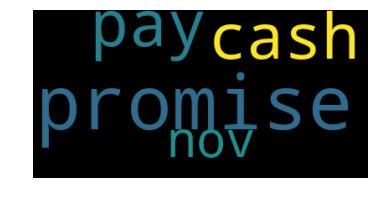

In [458]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [459]:
#Making word cloud of total words present in the comment column of the train dataset
text = " ".join(comm for comm in train.comment)

In [460]:
print("There are {} words in combination of all comments".format(len(text)))

There are 230230 words in combination of all comments


In [461]:
wordcloud = WordCloud().generate(text)

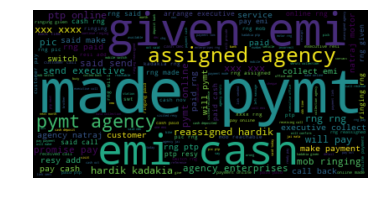

In [462]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()